In [1]:
#import ROOT
import uproot
import matplotlib.pyplot as plt

import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
import pylandau

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Vt = -1.25 #V


In [3]:
RunCs = uproot.open('../dati/Run_ch2_Cs_Measurements_Only_3_21_2024 (2).root')
RunCsBis = uproot.open('../Dati/Run_ch2_Cs_Measurements_Only_3_21_2024_BIS.root')

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
chargeCsBis = np.array(RunCsBis['tree'].arrays()['charge'])

ampCs = np.array(RunCs['tree'].arrays()['amp'])
ampCsBis = np.array(RunCsBis['tree'].arrays()['amp'])

chargeCs = np.append(chargeCs,chargeCsBis)
ampCs = np.append(ampCs,ampCsBis)

RunNoise = uproot.open('../dati/Run_ch2_X_Measurements_Only_3_21_2024 (1).root')
RunNoiseBis = uproot.open('../dati/Run_ch2_X_Measurements_Only_3_21_2024_BIS.root')

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
chargeNBis = np.array(RunNoiseBis['tree'].arrays()['charge'])

ampN = np.array(RunNoise['tree'].arrays()['amp'])
ampNBis = np.array(RunNoiseBis['tree'].arrays()['amp'])

chargeN = np.append(chargeN,chargeNBis)
ampN = np.append(ampN,ampNBis)

evCs = np.array(RunCs['tree'].arrays()['ev'])[-1]
evCsBis = np.array(RunCsBis['tree'].arrays()['ev'])[-1]
evCsT = evCs+evCsBis

evN = np.array(RunNoise['tree'].arrays()['ev'])[-1]
evNBis = np.array(RunNoiseBis['tree'].arrays()['ev'])[-1]
evNT = evN+evNBis
print(evNT)
print(evCsT)

TCs = 428 #s
TN = 642 #s

rateCs = evCsT/TCs
rateN = evNT/TN


BalancedEv = TCs*rateN
print("la rate del segnale e':",round(rateCs,2))
print("la rate del rumore e'",round(rateN,2))
print("Il numero corretto di seganale da tenere in considerazione e'",BalancedEv)


150000
200000
la rate del segnale e': 467.29
la rate del rumore e' 233.64
Il numero corretto di seganale da tenere in considerazione e' 100000.0


In [4]:
trueCs = ampCs>Vt
chargeCs = chargeCs[trueCs]

trueX = ampN>Vt
chargeN = chargeN[trueX]
#chargeN=np.append(chargeN, chargeN)
print(len(chargeN))


149688


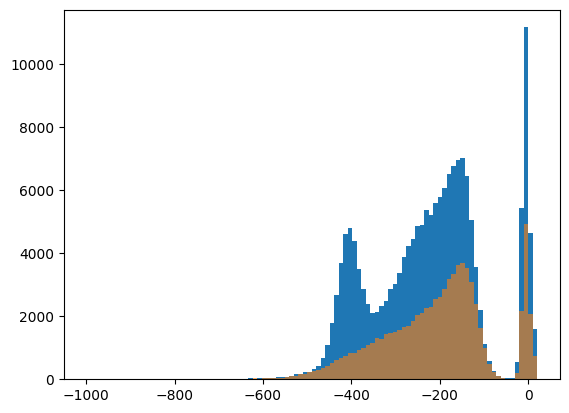

In [5]:
bin = 100


bin1,edge1,_ = plt.hist(chargeCs, bins=bin, range=(-1000,20))
bin2,edge2,_= plt.hist(chargeN[:BalancedEv.astype(int)], bins=bin, range=(-1000,20), alpha=0.6)
#plt.xlim(-350, -140)

In [12]:
plt.bar(edge2[1:],binTot,width=15)
""""
cov=(np.mean(bin1*bin2)-np.mean(bin1)*np.mean(bin2))
print(cov)
corr=cov/(np.std(bin1)*np.std(bin2))
print(corr)
"""
err=np.sqrt(bin1+bin2)
plt.errorbar(edge2[1:], binTot, err*2, color='red', fmt='|')
plt.title("Spettro del Cesio")
plt.ylabel("counts")
plt.xlabel("charge [pC]")
plt.savefig("SpettroSchifo.pdf")

NameError: name 'binTot' is not defined

# Prova del fit del noise con curve fit e monte carlo

In [116]:
def check(el):
    if (el < -150 and  el > -350) :#or (el < -450 and el > -600):  prendo gli elementi che sono prima del picco fotoelettrico
        return (el)
    else:
        return None
def exp(x, a, b, c, d):
    return a*np.exp((x+b)*c) + d


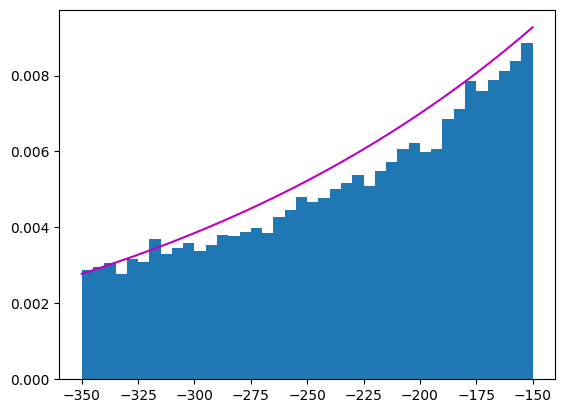

In [129]:
n_bin=40 #per non everbinnare
new_charge=[]
for el in chargeN[:BalancedEv.astype(int)]:
    if check(el) != None:
        new_charge.append(check(el))
bins, edges, _=plt.hist(new_charge, bins=n_bin, density=True)  #per non far venire numeri troppo grandi normalizzo l'istogramma

plt.plot(edges, 0.008*(np.exp((edges+200)*0.005))-0.001, color='m')   #esponenziale di prova


new_edge=[]
for i in range(0,n_bin):
    new_edge.append((edges[i+1]+edges[i])/2)
new_edge=np.array(new_edge)



0.00701509222233003 * exp((x+151.67086885013882)*0.009709157429404197) + 0.001855664398053256
errori: 6792.404871246592, 99726054.08501609, 0.0007755704237210617, 0.0002450520487309151


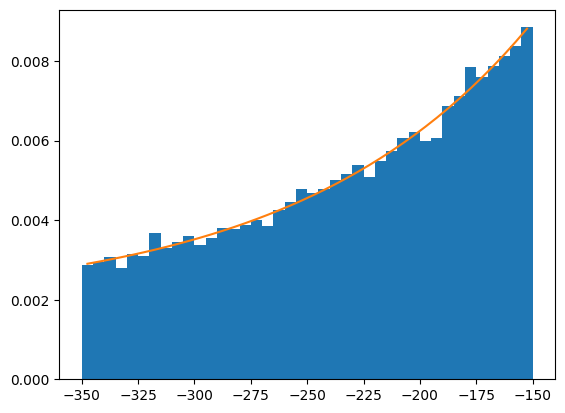

In [130]:
par, cov=curve_fit(exp, new_edge, bins, p0=[0.008, 200, 0.005, -0.001])
print('{0} * exp((x+{1})*{2}) + {3}'.format(par[0], par[1], par[2], par[3]))
print('errori: {0}, {1}, {2}, {3}'.format(np.sqrt(cov[0][0]), np.sqrt(cov[1][1]), np.sqrt(cov[2][2]), np.sqrt(cov[3][3])))
_=plt.hist(new_charge, bins=40, density=True)
plt.plot(new_edge, exp(new_edge, par[0], par[1], par[2], par[3]))
#y_landau = pylandau.landau(new_edge)
 #plt.plot(new_edge, y_landau)

In [131]:
#gli errori sono molto grandi, provo a fare montecarlo


In [132]:
def log_likelihood(theta, x, y, yerr):   #used by emcee . d:data we gathered. theta are {parameters} will change and I is the info we have
    #x and sigma are related to how I perform the measurements. Extra parameter f in the problem. We take each data point yk and remove the 
    #linear dependencece mxk+q  and modulate with sk which is just not sigma, but modulated by f. Modelling: slope, intercept, 
    #amplitude of additional noise component of each point. 
    #Function where we have theta parameters, x, yerr and value of measurments
    a, b, c, d = theta   #parameters
    model = a*np.exp((x+b)*c) + d  #what model predicts (np.array) 
    sigma2 = yerr ** 2 #+ model ** 2 * np.exp(2 * log_f) #"official" error bar 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))  #definition of likelyhood

Success status: False
Desired error not necessarily achieved due to precision loss.
Maximum likelihood estimates:
a = 0.0070 
b = 151.6709
c = 0.0097
d = 0.0019


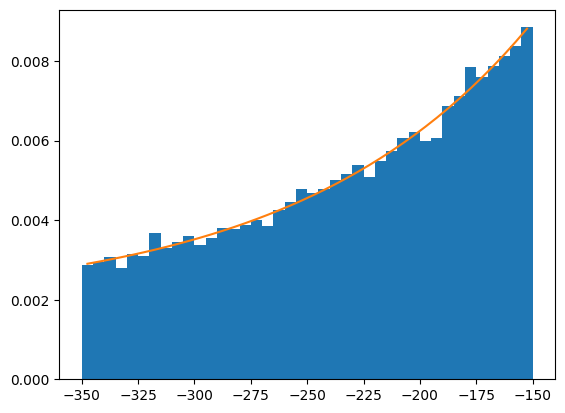

In [134]:
from scipy.optimize import minimize  #minimize function
x=new_edge
y=bins
yerr=0.0001
# Reproducible results
np.random.seed(42)

# Initial guess for the parameters (make it imperfect with Gaussian noise)
initial = np.array((0.00701509222233003, 151.67086885013882, 0.009709157429404197, 0.001855664398053256))

# Solve by minimization of -log-likelihood!
soln = minimize(lambda *args: -log_likelihood(*args), initial, args=(x, y, yerr))

# Check whether it converged
print("Success status:", soln.success)  #info returned by minimize
print(soln.message)

# Extract maximum likelihood parameter values
a, b, c, d = soln.x  #numbers we were looking for
print("Maximum likelihood estimates:")
print("a = {0:.4f} ".format(a))
print("b = {0:.4f}".format(b))
print("c = {0:.4f}".format(c))
print("d = {0:.4f}".format(d))

# Plot all together
bins, edges, _=plt.hist(new_charge, bins=40, density=True)
plt.plot(new_edge, exp(new_edge, a, b, c, d))
#don't really care about f. How to integrate away f?

In [135]:
def log_prior(theta):   #contains all parameters
    a, b, c, d = theta
    # Return a finite value if theta is in the parameter space region with support for the prior
    if 0 < a < 0.01 and 100 < b < 200 and 0 < c < 0.1 and 0 < d < 0.1:
        return 0.0
    # Otherwise return -infinity, basically a massive down-weight for the posterior
    return -np.inf   #these are log, log0=-inf

In [136]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    # If theta is outside the support for the prior, return -infinity
    if not np.isfinite(lp):    #something outside support region for the prior
        return -np.inf
    # Otherwise return the logarithm of prior*likelihood, i.e. log_prior + log_likelihood
    return lp + log_likelihood(theta, x, y, yerr)  #operate with log

In [138]:
import emcee

In [143]:
# The number of walkers      #look theta and prior, if it is finite or not. Accumulating information to compute rhs.
nwalkers = 32

# The dimensionality of the parameter space (m, q, ln(f))
ndim = 4

# The MCMC steps
nmcmc = 500000   #brute force to stop
#nested sampling integrates p exploring parameter space. Evidence       check convergence (on local maximum) and threshold 
#on evidence to stop sampling
# Initial positions of the 32 walkers
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
#we move a little bit away from our initial guess
# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, nmcmc, progress=True) # The ; avoids some prints to screen

 ... (more hidden) ...


State([[8.11787091e-03 1.37870371e+02 9.70822671e-03 1.81826060e-03]
 [7.24944338e-03 1.49874130e+02 9.03974286e-03 1.67136829e-03]
 [7.94127281e-03 1.36987148e+02 1.06890726e-02 2.13804605e-03]
 [5.36855158e-03 1.84371248e+02 9.08701737e-03 1.61318271e-03]
 [5.62489331e-03 1.76080919e+02 9.81298444e-03 1.78849351e-03]
 [8.83029885e-03 1.26038324e+02 9.84326608e-03 1.97857504e-03]
 [9.97773130e-03 1.14604459e+02 9.61331150e-03 1.86469589e-03]
 [5.59489324e-03 1.72836147e+02 1.00357791e-02 1.96180780e-03]
 [8.81832055e-03 1.27425482e+02 9.87956475e-03 1.90998893e-03]
 [5.49779274e-03 1.73639532e+02 1.04926313e-02 2.02615016e-03]
 [7.97564553e-03 1.38928311e+02 9.44187102e-03 1.76423522e-03]
 [6.92073564e-03 1.50331638e+02 1.02931908e-02 2.08573498e-03]
 [6.69631168e-03 1.57531201e+02 9.67697105e-03 1.82486734e-03]
 [9.90925990e-03 1.15339371e+02 9.27317927e-03 1.69992804e-03]
 [9.88144303e-03 1.14690636e+02 9.51412742e-03 1.84908427e-03]
 [6.02606773e-03 1.69943282e+02 9.50861230e-03 1.

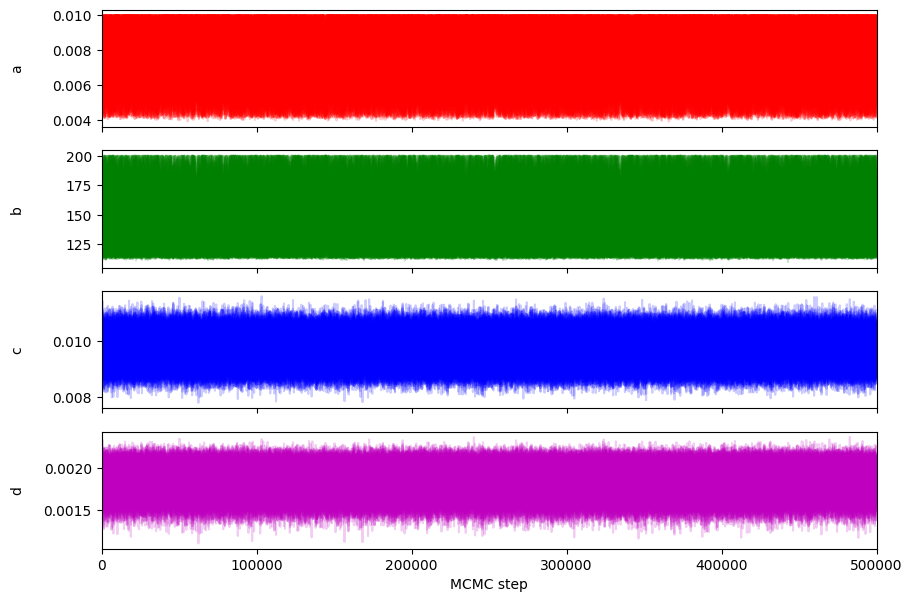

In [144]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "d"]
col = ['r', 'g', 'b', 'm']
for i in range(ndim):  #cycling over dimensionality, consider all walkers and parameters
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2)  #use all walkers
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step"); # The ; avoids an unwanted output to screen.

In [145]:
tau = sampler.get_autocorr_time()    #how much few steps to look for autocorrelation time
#steps to lose info about where the chain was before
print(tau)    #after 50 steps I forget where I was

[579.63078154 609.05698046 116.68454377 117.09157655]


In [146]:
flat_samples = sampler.get_chain(discard=700, thin=20, flat=True)  #we throw away 100 samples to have independence.
#evry random sampler walker has some correlation inside
print(flat_samples.shape)  #one walker with independent samples

(798880, 4)


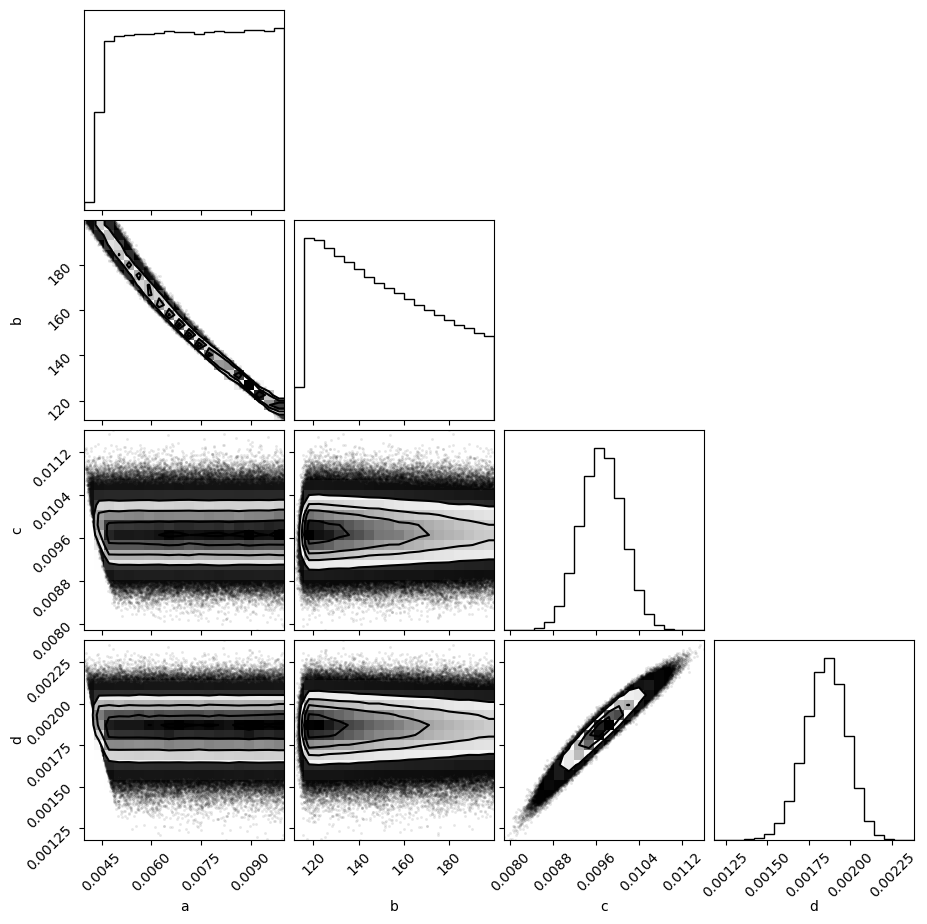

In [157]:
import corner
fig = corner.corner(flat_samples, labels=['a','b', 'c', 'd'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


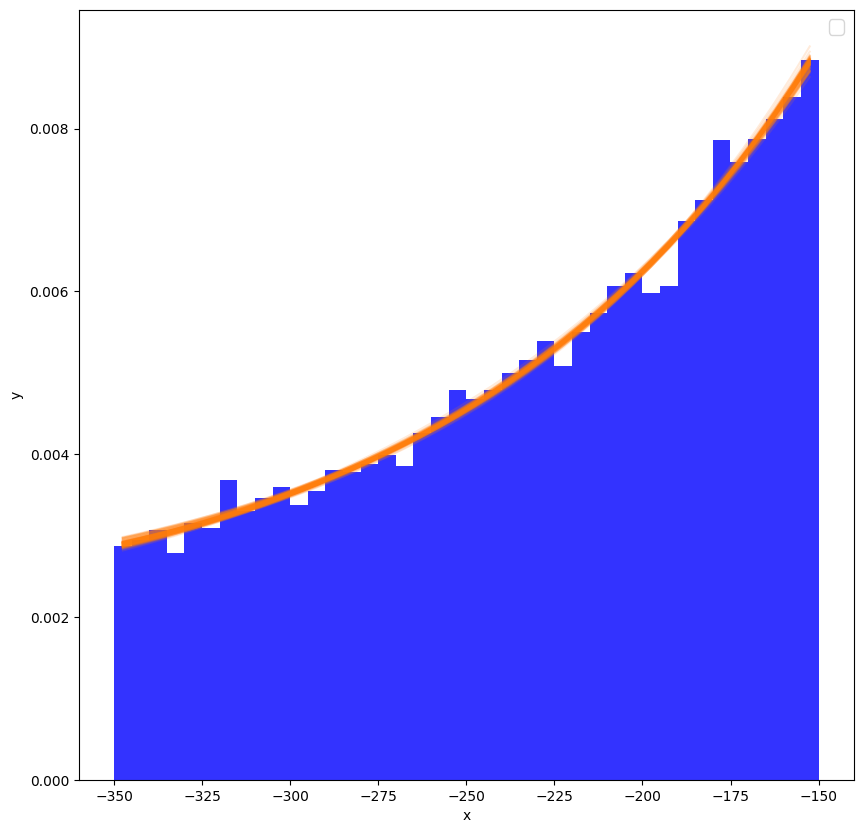

In [154]:
inds = np.random.randint(len(flat_samples), size=100)   #look at original data

fig = plt.figure(figsize=(10,10))
_=plt.hist(new_charge, bins=40, density=True, alpha=0.8, color='b')


for ind in inds:
    sample = flat_samples[ind]
    # Fancy way of doing m*x0+q for all x0 values, given m and q from the sample:
    # take the dot product between all (x0,1) pairs and one (m,q) at a time
    plt.plot(x, exp(x, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.15)

#plt.plot(x0, m_true * x0 + q_true, "k", label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [152]:
print("curve fit: {0}, {1}, {2}, {3}".format(a,b,c,d))
print("mcmc: {0}, {1}, {2}, {3}". format (sample[0], sample[1], sample[2], sample[3]))

curve fit: 0.00701509222233003, 151.67086885013882, 0.009709157429404197, 0.001855664398053256
mcmc: 0.004800336083960624, 191.92390659321327, 0.009527059647492892, 0.0018210508175329396
